In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [2]:
BASE_DIR = 'UTKFace'


In [3]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/3660 [00:00<?, ?it/s]

In [4]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()47

,image,age,gender
0,UTKFace\100_1_2_20170112213615815.jpg.chip.jpg,100,1
1,UTKFace\105_1_0_20170112213001988.jpg.chip.jpg,105,1
2,UTKFace\10_0_0_20170110220033115.jpg.chip.jpg,10,0
3,UTKFace\10_0_0_20170110220403810.jpg.chip.jpg,10,0
4,UTKFace\10_0_0_20170110224549512.jpg.chip.jpg,10,0


In [5]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}


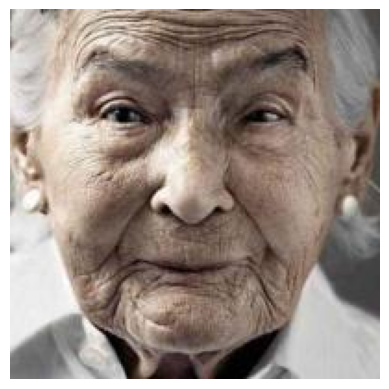

In [6]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

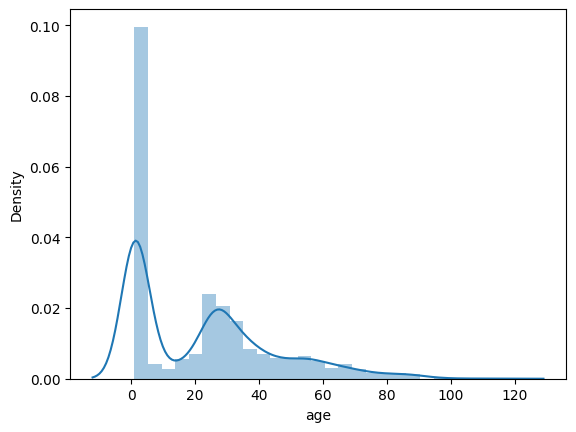

In [7]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

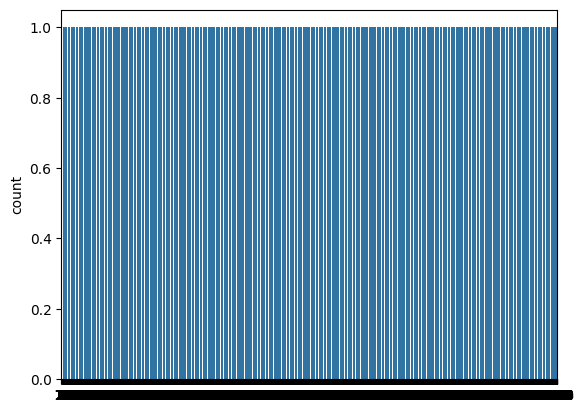

In [8]:
sns.countplot(df['gender'])


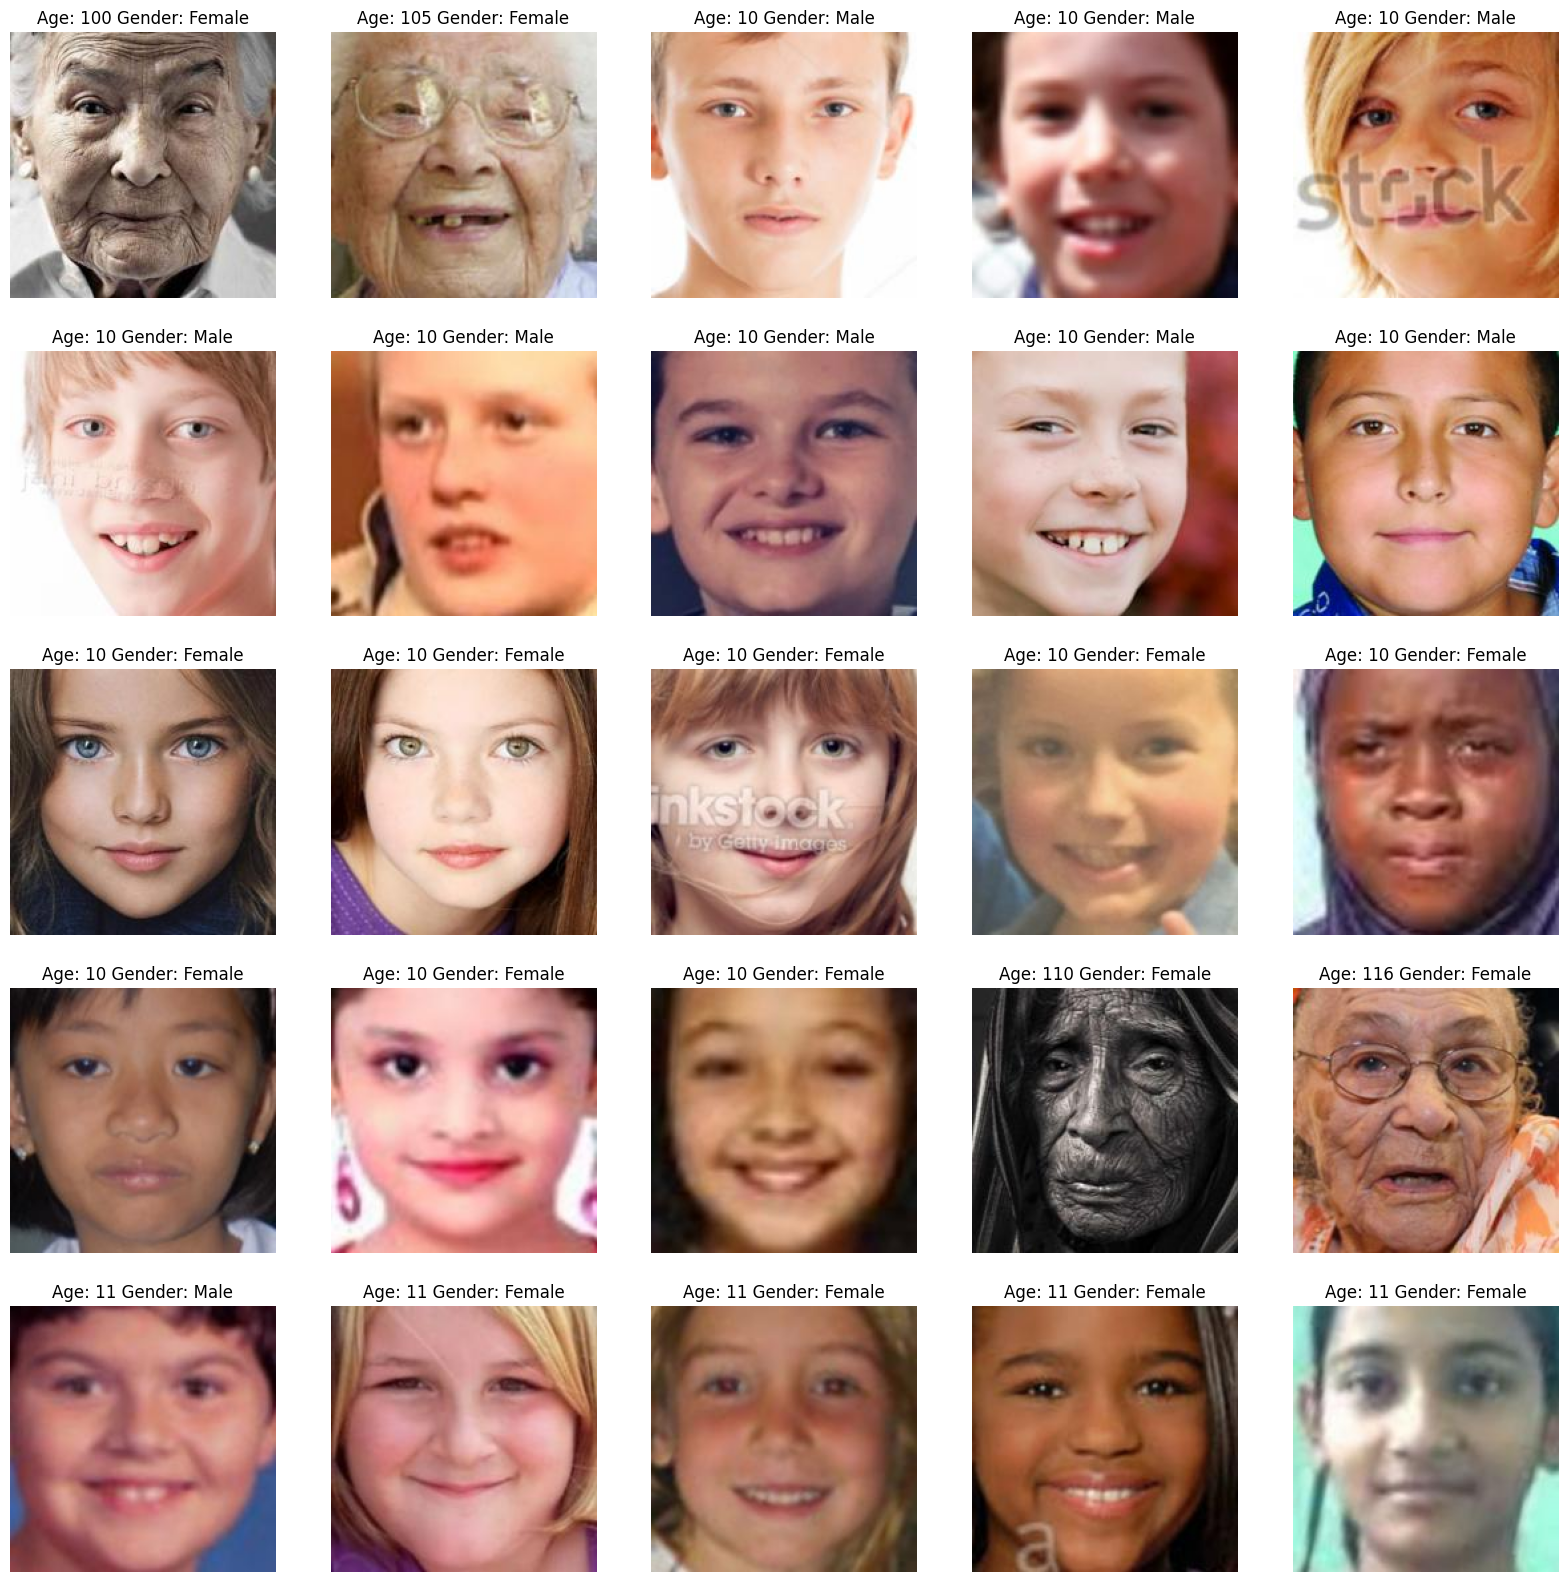

In [9]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
from tqdm import tqdm
import numpy as np
from keras.preprocessing.image import load_img
from PIL import Image

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)  # Corrected here
        img = np.array(img)
        features.append(img)
    return np.array(features)

# Assuming df['image'] contains the list of image paths
X = extract_features(df['image'])


100%|████████████████████████████████████████████████████████████████████████████| 3660/3660 [00:03<00:00, 1207.58it/s]


In [13]:
X.shape

(3660, 128, 128)

In [14]:
# normalize the images
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 1)

In [17]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [19]:
!pip install pydot

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [21]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - age_out_mae: 12.1131 - gender_out_accuracy: 0.5555 - loss: 12.8114 - val_age_out_mae: 40.9503 - val_gender_out_accuracy: 0.6708 - val_loss: 41.5631
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - age_out_mae: 6.9316 - gender_out_accuracy: 0.6073 - loss: 7.5912 - val_age_out_mae: 28.9040 - val_gender_out_accuracy: 0.7268 - val_loss: 29.4746
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - age_out_mae: 5.2807 - gender_out_accuracy: 0.6210 - loss: 5.9225 - val_age_out_mae: 33.3787 - val_gender_out_accuracy: 0.7377 - val_loss: 33.9350
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 318ms/step - age_out_mae: 4.8050 - gender_out_accuracy: 0.6536 - loss: 5.4336 - val_age_out_mae: 32.1135 - val_gender_out_accuracy: 0.7609 - val_loss: 32.6361
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 291ms/step - age_out_mae: 4.3871 - gender_out_accuracy: 0.6565 - loss: 4.9965 - val_age_out_mae: 30.8623 - val_gender_out_accuracy: 0.7391 - val_loss: 3

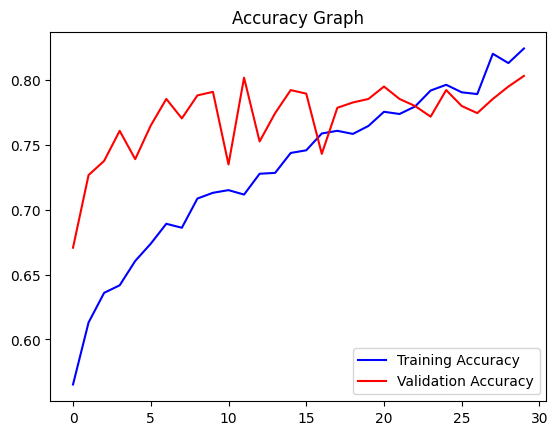

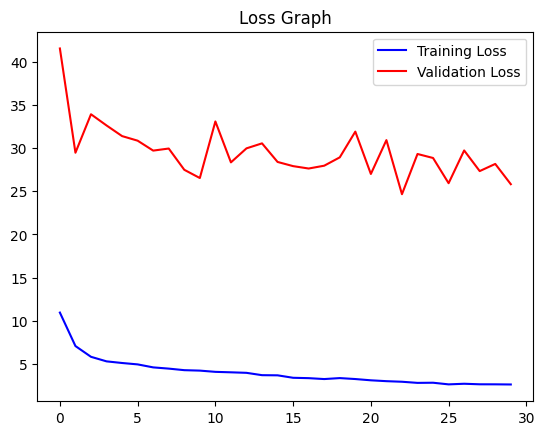

In [22]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Gender: Male Predicted Age: 21


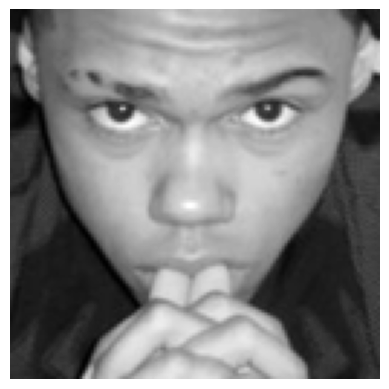

In [27]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [ ]:
import matplotlib.pyplot as plt

# Ensure that the input is a valid index
while True:
    try:
        image_index = int(input(f"Enter the image index (0 to {len(X) - 1}): "))
        if 0 <= image_index < len(X):
            break
        else:
            print(f"Please enter a number between 0 and {len(X) - 1}.")
    except ValueError:
        print("Invalid input. Please enter an integer.")

# Print the original gender and age for the specified index
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# Predict from the model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))

# Determine the predicted gender and age
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

# Print the predicted gender and age
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Display the image
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
plt.show()
